# Extracting relevant information to construct seed values for linear mixing endmember spectra

In [60]:
import import_ipynb
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.stats import gaussian_kde


import torch
import torch .nn as nn
import torch .optim as optim

import json

import gc

from tqdm.notebook import tqdm

plt.rcParams['text.usetex'] = True

In [2]:
data = np.loadtxt("../data/RaCA-spectra-first1000.csv",
                 delimiter=",", dtype=str)

In [3]:
data[0,2152:]
sample_top   = data[1:,2153].astype('float32')
sample_bot   = data[1:,2154].astype('float32')
sample_txtr  = data[1:,2156]
sample_bd    = data[1:,2158].astype('float32')
sample_bdsd  = data[1:,2159].astype('float32')
sample_soc   = data[1:,2162].astype('float32')
sample_socsd = data[1:,2163].astype('float32')

In [4]:
dataI = data[1:,1:2152].astype('float32')
XF = np.array([x for x in range(350,2501)]);

# Fit to 100/1,000 data points

In [5]:
KEndmembers = 90
NPoints = 100
NData = 999
MSpectra = 2151

### Pull F's and m_{SOC}'s, generate seed m's and alphas

In [6]:
# load JSON file with pure spectra
endMemMap = json.load(open('../data/endmember spectral data.json'))

# get reflectance spectra (y axis) and wavelength grid (x axis)
endMemList = [x for x in endMemMap.keys()];
endMemList.remove("General")
XF = endMemMap["General"]["Postprocessed Wavelength Axis [nm]"]
F = [endMemMap[x]["Postprocessed Reflectance"] for x in endMemList]

# get density, radius info and merge into relevant arrays
rhos = [endMemMap[x]["Density (Mg/m^3)"] for x in endMemList]
rads = [endMemMap[x]["Effective Radius (nm)"] for x in endMemList]

/var/folders/6w/zm__23zx1fn9ljlttn9tntb40000gn/T/ipykernel_62464/2821050095.py:12: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0,35])


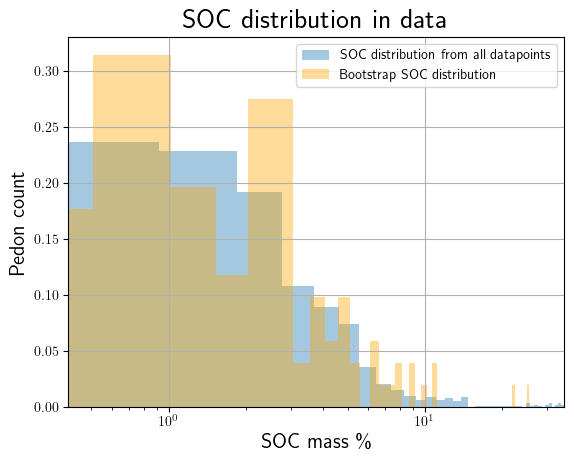

In [7]:
dataIndices = np.random.choice(NData,NPoints,replace=False)
msoc = sample_soc[dataIndices]

hist, bins = np.histogram(sample_soc, bins=50)

plt.hist(sample_soc, bins=50, density=True, alpha=0.4, label='SOC distribution from all datapoints')
plt.hist(msoc, bins=50, density=True, alpha=0.4, color='orange', label='Bootstrap SOC distribution')
plt.xlabel("SOC mass \%",fontsize=15)
plt.ylabel("Pedon count",fontsize=15)
plt.title("SOC distribution in data",fontsize=20)
plt.xscale('log')
plt.xlim([0,35])
plt.legend()
plt.grid()

del hist, bins

msoc=msoc/100.0

In [8]:
def gaus(mu, sigma, N=1) :
    return np.random.randn(N) * sigma + mu;

In [74]:
# generate seed alphas from seed M's, specified below from initial literature
seedMsDict = {}
def genSeedMs() :
    for endMem in endMemList :
        if "Coarse measure of average abundance" in endMemMap[endMem] :
            seedMsDict[endMem] = float(endMemMap[endMem]["Coarse measure of average abundance"])/100.
        else :
            print("\t - Mineral",endMem,"Does not have any abundance set in the JSON file.")

    # collect constant seeds from the definitions above
    seedMs = [seedMsDict[x] if x in seedMsDict else 0.0 for x in endMemList]
    seedMs = seedMs + [0.0]

    # make seedMs an N x K matrix
    seedMs = np.ones([NPoints,KEndmembers]) * seedMs
    seedMs[:,KEndmembers-1] = msoc
    seedMrem = 1.0 - np.sum(seedMs,axis=1)

    # if seedM remainder is < 0, SOC exceeds pre-defined content,
    # so rescale pre-defined values, fix SOC to prior value, and set rest to 0
    seedMNegRem = (seedMs.T * (seedMrem < 0.0).astype('float32') / np.sum(seedMs[:,:-1],axis=1) * (1.0 - msoc)).T
    seedMNegRem[:,-1] = msoc * (seedMrem < 0.0).astype('float32')
    seedMs = (seedMs.T * (seedMrem >= 0.0).astype('float32')).T + seedMNegRem
    
    # get seeds that haven't been filled in yet, excluding SOC
    # if remaining mass fraction is < 0, exclude from further partitioning
    seedMZeros = ((seedMs == 0.0).astype('float32').T * (seedMrem > 0.0).astype('float32')).T
    
    # sample random remaining seeds and renormalize to the appropriate remainder
    seedMZeros = seedMZeros * np.random.random([NPoints,KEndmembers])
    seedMZeros[:,-1] = 0.0
    
    seedMZeros = (seedMZeros.T / (np.sum(seedMZeros,axis=1)+0.00000000001)).T
    seedMrem = 1.0 - np.sum(seedMs,axis=1)
    seedMZeros = (seedMZeros.T * seedMrem).T
    seedMZeros[:,-1] = 0.0

    # add remaining seeds into seedMs
    seedMs = seedMs + seedMZeros 

    del seedMZeros, seedMrem
    
    return seedMs

genSeedMs()

#seedMs = genSeedMs()

array([[0.00715934, 0.00943347, 0.00827273, ..., 0.00066667, 0.00827273,
        0.00475393],
       [0.00658548, 0.00122733, 0.00827273, ..., 0.00066667, 0.00827273,
        0.02673585],
       [0.00456108, 0.00519041, 0.00827273, ..., 0.00066667, 0.00827273,
        0.04811129],
       ...,
       [0.00662621, 0.00119635, 0.00827273, ..., 0.00066667, 0.00827273,
        0.09942249],
       [0.00391918, 0.00824051, 0.00827273, ..., 0.00066667, 0.00827273,
        0.02150084],
       [0.00844141, 0.00427643, 0.00827273, ..., 0.00066667, 0.00827273,
        0.00779824]])

### Generate SOC seed F

In [10]:
def fakeTrough(x,mu,sigma) :
    return 0.1*np.exp(-(x-mu)**2/2.0/sigma)

organicTroughs = [1650,1100,825,2060,1500,1000,751,1706,1754,1138,1170,853,877,1930,1449,2033,1524,2275,1706,1961,2137,2381,1400,1900,1791,2388]

tFsoc = np.sum(dataI.T * sample_soc,axis=1)/np.sum(sample_soc)
trueFsoc = tFsoc - 0.125*np.sum(fakeTrough((np.zeros([1,MSpectra])+XF).T,np.array(organicTroughs),3000).T,axis=0)
seedFsoc = tFsoc - 0.125*gaus(1.0,0.5)*np.sum(fakeTrough((np.zeros([1,MSpectra])+XF).T,np.array(organicTroughs),3000*gaus(1.0,0.25,len(organicTroughs))).T,axis=0)

F = [endMemMap[x]["Postprocessed Reflectance"] for x in endMemList]
F = np.array(F + [seedFsoc])

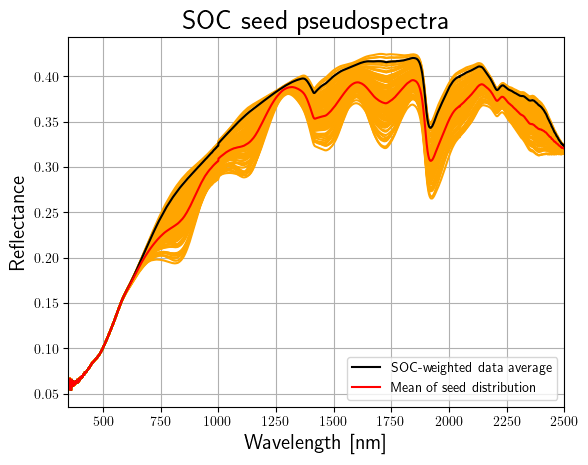

In [11]:
# Generate many seeds for comparison
seedFsocs = np.tile(tFsoc,(100,1))

for i in range(seedFsocs.shape[0]) :
    seedFsocs[i,:] = seedFsocs[i,:] - 0.125*gaus(1.0,0.5)*np.sum(fakeTrough((np.zeros([1,MSpectra])+XF).T,np.array(organicTroughs),3000*gaus(1.0,0.25,len(organicTroughs))).T,axis=0)
    
plt.plot(XF,seedFsocs.T, 'orange')
plt.plot(XF,tFsoc.T, 'black',label="SOC-weighted data average")

plt.plot(XF,trueFsoc.T, 'red', label="Mean of seed distribution")

plt.legend()

plt.xlim([350,2500])

plt.xlabel("Wavelength [nm]",fontsize=15)
plt.ylabel("Reflectance",fontsize=15)
plt.title("SOC seed pseudospectra",fontsize=20)
plt.grid()

#plt.ylim([0,1.1])

### Generate reflectance pseudodata from mixing model

In [12]:
def A(ms,rhorads) :
    tA = ms / rhorads
    return (tA.T / np.sum(tA,axis=1)).T

def torchA(ms,rhorads) :
    tA = ms / rhorads
    return (tA.t() / torch.sum(tA,axis=1)).t()

rhorads = np.array(rhos)*np.array(rads)
trueSOCrr = np.mean(rhorads)
seedSOCrr = (np.mean(rhorads)*gaus(1.0,0.2))
seedAs = A(seedMs,np.append(rhorads,seedSOCrr))

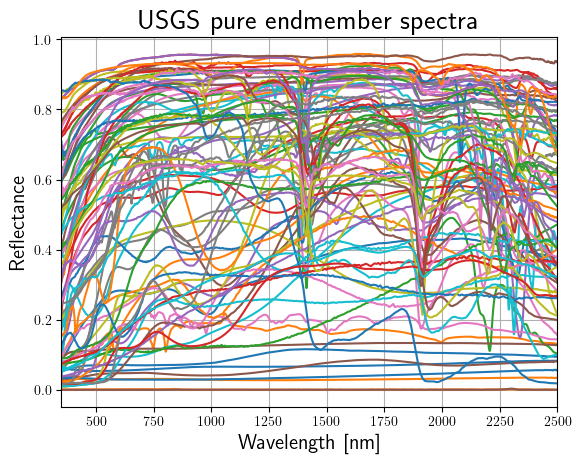

In [13]:
plt.plot(XF,F.T);
plt.xlabel(r'Wavelength [nm]',fontsize=15)
plt.ylabel(r'Reflectance',fontsize=15)
plt.title(r'USGS pure endmember spectra',fontsize=20)
plt.xlim([350,2500])
plt.grid()

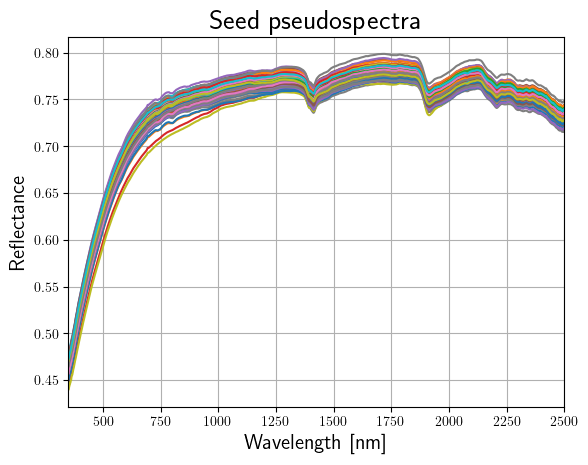

In [14]:
plt.plot(XF,np.dot(seedAs,F).T);
plt.xlabel(r'Wavelength [nm]',fontsize=15)
plt.ylabel(r'Reflectance',fontsize=15)
plt.title(r'Seed pseudospectra',fontsize=20)
plt.xlim([350,2500])
plt.grid()
#plt.plot(XF,maxI.T,'b');

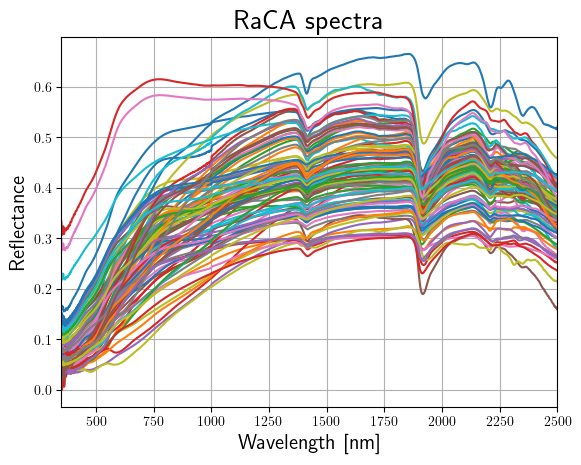

In [15]:
plt.plot(XF,dataI[dataIndices].T);
plt.xlabel(r'Wavelength [nm]',fontsize=15)
plt.ylabel(r'Reflectance',fontsize=15)
plt.title(r'RaCA spectra',fontsize=20)
plt.xlim([350,2500])
plt.grid()

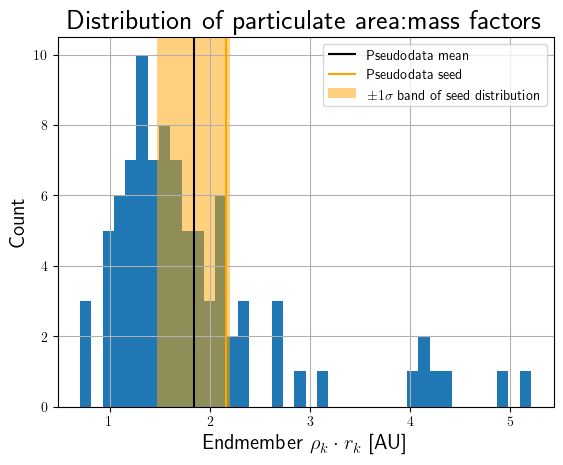

In [16]:
f, ax = plt.subplots()
th = plt.hist(rhorads,bins=40);
plt.xlabel(r'Endmember $\rho_k \cdot r_k$ [AU]',fontsize=15)
plt.ylabel(r'Count',fontsize=15)
plt.title(r'Distribution of particulate area:mass factors',fontsize=20)
plt.grid()

plt.vlines(trueSOCrr,ymin=0,ymax=np.max(th[0])*1.05,color='black',label=r'Pseudodata mean');
plt.vlines(seedSOCrr,ymin=0,ymax=np.max(th[0])*1.05,color='orange',label=r'Pseudodata seed');
ax.add_patch(Rectangle((trueSOCrr*0.8,0),trueSOCrr*0.4,np.max(th[0])*1.05,facecolor="orange",alpha=0.5,label=r'$\pm1\sigma$ band of seed distribution'));
plt.ylim([0,np.max(th[0])*1.05])
plt.legend()
plt.show()

### Run fit

In [17]:
class LinearMixingModel(nn.Module):
    def __init__(self, seedFs, seedFsoc, seedMs, rhorad, seedrrsoc, nepochs):
        super().__init__()
        # fixed quantities
        self.rhorad = rhorad
        self.fs     = seedFs
        
        # model parameters
        self.fsoc   = nn.Parameter(seedFsoc)
        self.rrsoc  = nn.Parameter(seedrrsoc)
        self.ms     = nn.Parameter(seedMs)
        
        # model output
        self.Ihat   = 0;
        
        # variables for tracking optimization
        self.epoch = 0;
        self.nepochs = nepochs;
        
        self.lsq = np.zeros(nepochs);
        self.loss = np.zeros(nepochs);
        self.bdsALoss = np.zeros(nepochs);
        self.bdsFLoss = np.zeros(nepochs);
        self.omrsLoss = np.zeros(nepochs);
        self.diffloss1 = np.zeros(nepochs);
        self.difflossfull = np.zeros(nepochs);
        
        
    def forward(self, y):
        msocs,Is,Imax = y
        rrFull    = torch.cat((self.rhorad,self.rrsoc))
        mFull     = torch.cat((self.ms,msocs.unsqueeze(1)),dim=1)
        mFull     = (mFull.t() / torch.sum(mFull,axis=1)).t()
        fFull     = torch.cat((self.fs,self.fsoc.unsqueeze(0)),dim=0)
        self.Ihat = torch.matmul(torchA(mFull,rrFull).float(),fFull.float())
                
        # Add in a fake Lagrange multiplier to discourage abundances < 0.001 or > 0.999
        oobsA = torch.sum((mFull < 0.001).float() * (mFull - 0.001)**2) 
        oobsA = oobsA + torch.sum((mFull > 0.999).float() * (mFull + 0.001 - 1.0) **2)

        # Add in a fake Lagrange multiplier to discourage Fsoc < 0 and Fsoc > 1
        oobsF = 1.0 * torch.sum((self.fsoc < 0.0).float() * (self.fsoc ** 2)) 
        oobsF = oobsF + 1.0 * torch.sum((self.fsoc > 1.0).float() * (1.0 - self.fsoc) **2)
        
        # Add in 1st derivative loss to smooth the curves
        diffloss = torch.sum(torch.diff(self.fsoc) ** 2)
        self.diffloss1[epoch] = diffloss.detach().item();
        
        diffloss += torch.sum(torch.diff(torch.diff(self.fsoc)) ** 2)
        
        # Compute the loss function, which is the mean-squared error between data and prediction,
        # with a multiplicative factor for our fake Lagrange multipliers
        lsq = torch.sum((Is - self.Ihat) ** 2)
        loss = lsq * (1 + 10000.0*omrs + 100.0* diffloss + 100.0*oobsA + 1000.0*oobsF)
        
        # Report optimization statistics
        self.lsq[epoch]  = lsq.detach().item()
        self.loss[epoch] = loss.detach().item();
        self.bdsALoss[epoch] = oobsA.detach().item();
        self.bdsFLoss[epoch] = oobsF.detach().item();
        self.difflossfull[epoch] = diffloss.detach().item();
        
        epoch += 1;
        
        return loss
    

In [88]:
# seed data: A[1:,:] and initial F's
tF       = torch.tensor(F[:-1,:].tolist())
tFsoc    = torch.tensor(seedFsoc.tolist())
tseedMs  = torch.tensor(seedMs[:,:-1].tolist())
tmsoc    = torch.tensor(msoc.tolist())
trhorads = torch.tensor(rhorads.tolist())
trrsoc   = torch.tensor(seedSOCrr)

# empirical data: (SOC values, reflectances, and max normalized reflectance)
ys = (tmsoc,torch.tensor(dataI[dataIndices].tolist()),torch.tensor([]))

model = LinearMixingModel(tF,tFsoc,tseedMs,trhorads,trrsoc)
optimizer = optim.Adam(model.parameters(), lr = 0.00001, betas=(0.8,0.5))

for epoch in tqdm(range(100000)) :
    loss = model(ys)
    e = torch.mean(loss)
    e.backward()
    optimizer.step()
    optimizer.zero_grad()

print("Epoch ",epoch,": ", loss.detach().item(), model.lsq[-1])

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.26666259765625 2.6653380393981934


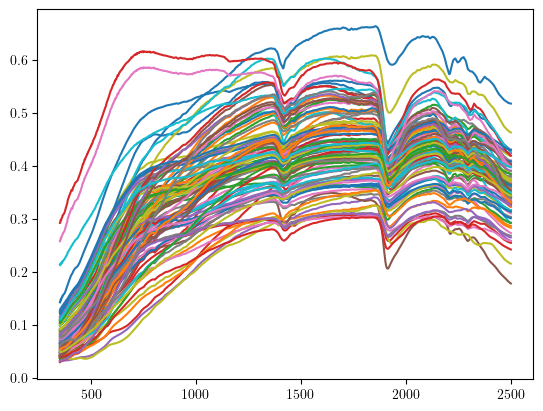

In [89]:
plt.plot(XF,model.Ihat.detach().numpy().T);

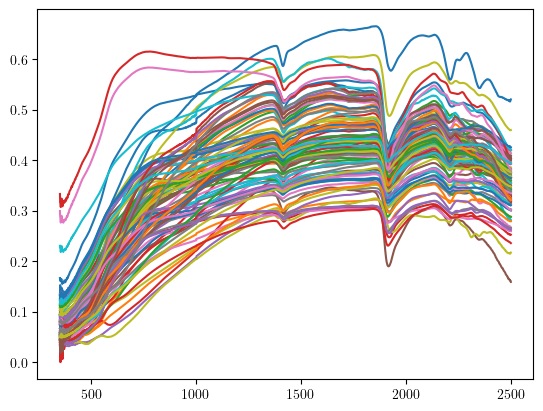

In [90]:
plt.plot(XF,dataI[dataIndices].T);

1.1635668741353264 2.1637262482330786 1.8363792196655018


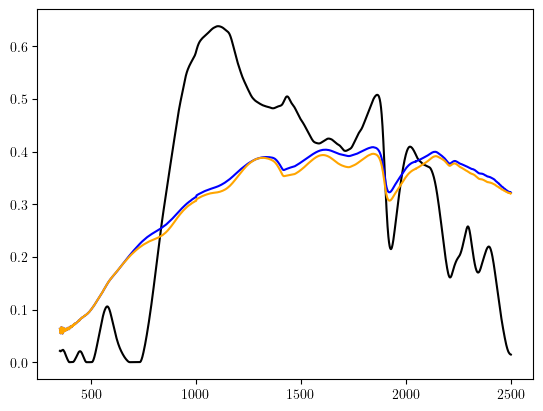

In [91]:
plt.plot(XF,model.fsoc.detach().numpy(),'black')
plt.plot(XF,seedFsoc,'blue')
plt.plot(XF,trueFsoc,'orange')
print(model.rrsoc.detach().item(),seedSOCrr[0],trueSOCrr)

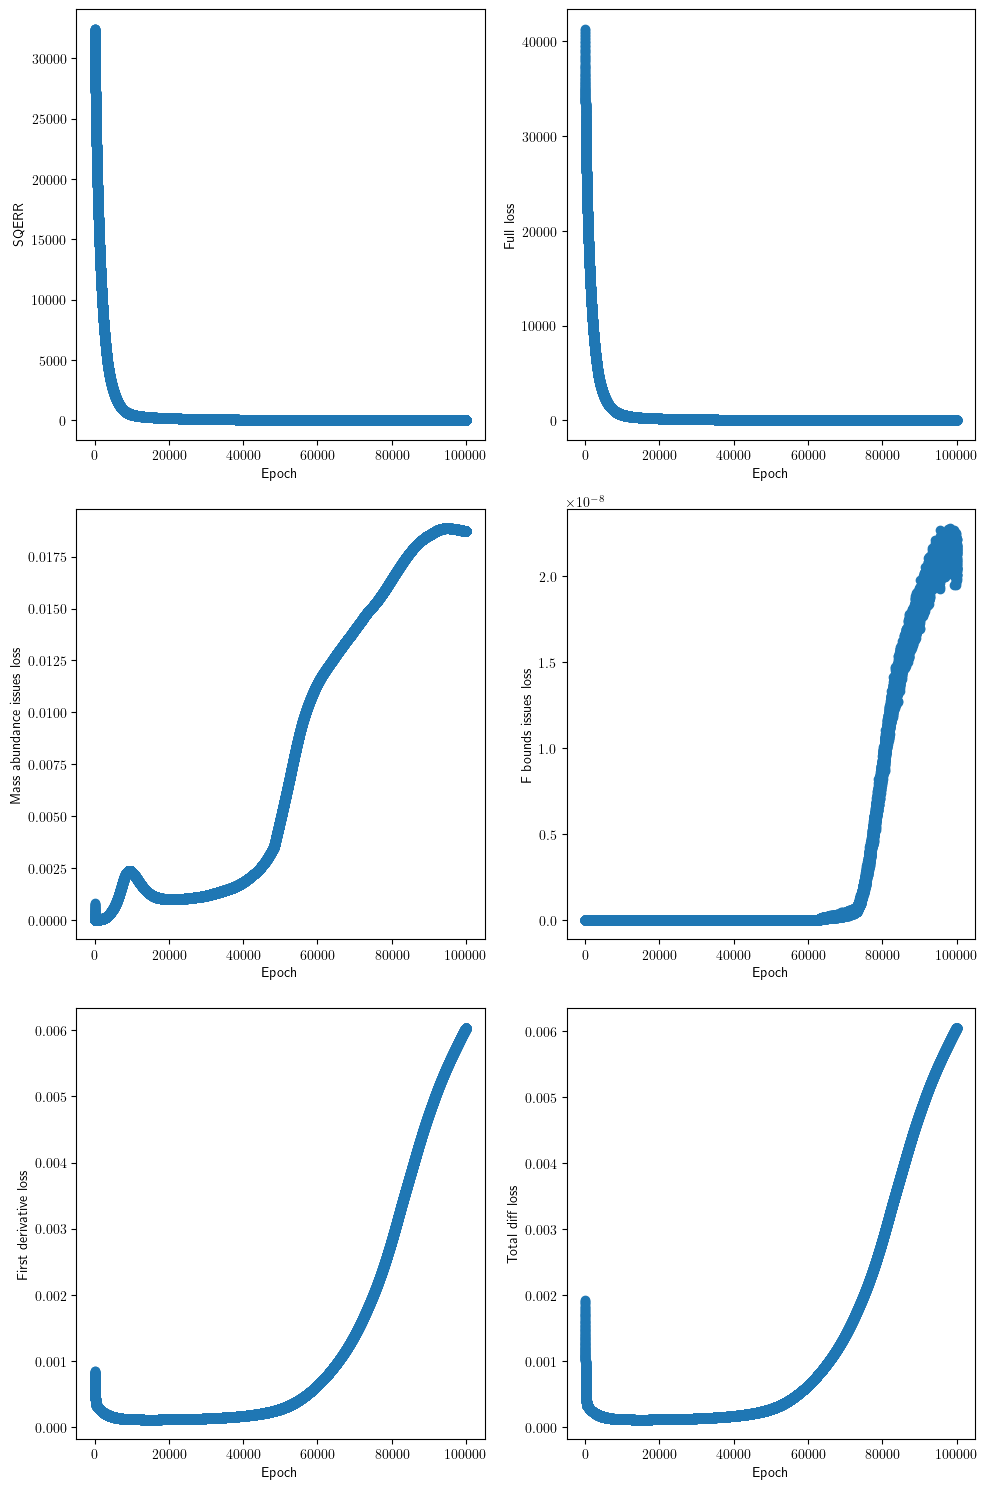

In [92]:
_, axarr = plt.subplots(3,2,figsize=(10,15))

axarr[0,0].scatter([i for i in range(len(model.lsq))],model.lsq)
axarr[0,0].set_xlabel("Epoch")
axarr[0,0].set_ylabel("SQERR")

axarr[0,1].scatter([i for i in range(len(model.loss))],model.loss)
axarr[0,1].set_xlabel("Epoch")
axarr[0,1].set_ylabel("Full loss")

axarr[1,0].scatter([i for i in range(len(model.bdsALoss))],model.bdsALoss)
axarr[1,0].set_xlabel("Epoch")
axarr[1,0].set_ylabel("Mass abundance issues loss")

axarr[1,1].scatter([i for i in range(len(model.bdsFLoss))],model.bdsFLoss)
axarr[1,1].set_xlabel("Epoch")
axarr[1,1].set_ylabel("F bounds issues loss")

axarr[2,0].scatter([i for i in range(len(model.diffloss1))],model.diffloss1)
axarr[2,0].set_xlabel("Epoch")
axarr[2,0].set_ylabel("First derivative loss")

axarr[2,1].scatter([i for i in range(len(model.difflossfull))],model.difflossfull)
axarr[2,1].set_xlabel("Epoch")
axarr[2,1].set_ylabel("Total diff loss")

plt.tight_layout()
plt.show()

  0%|          | 0/89 [00:00<?, ?it/s]

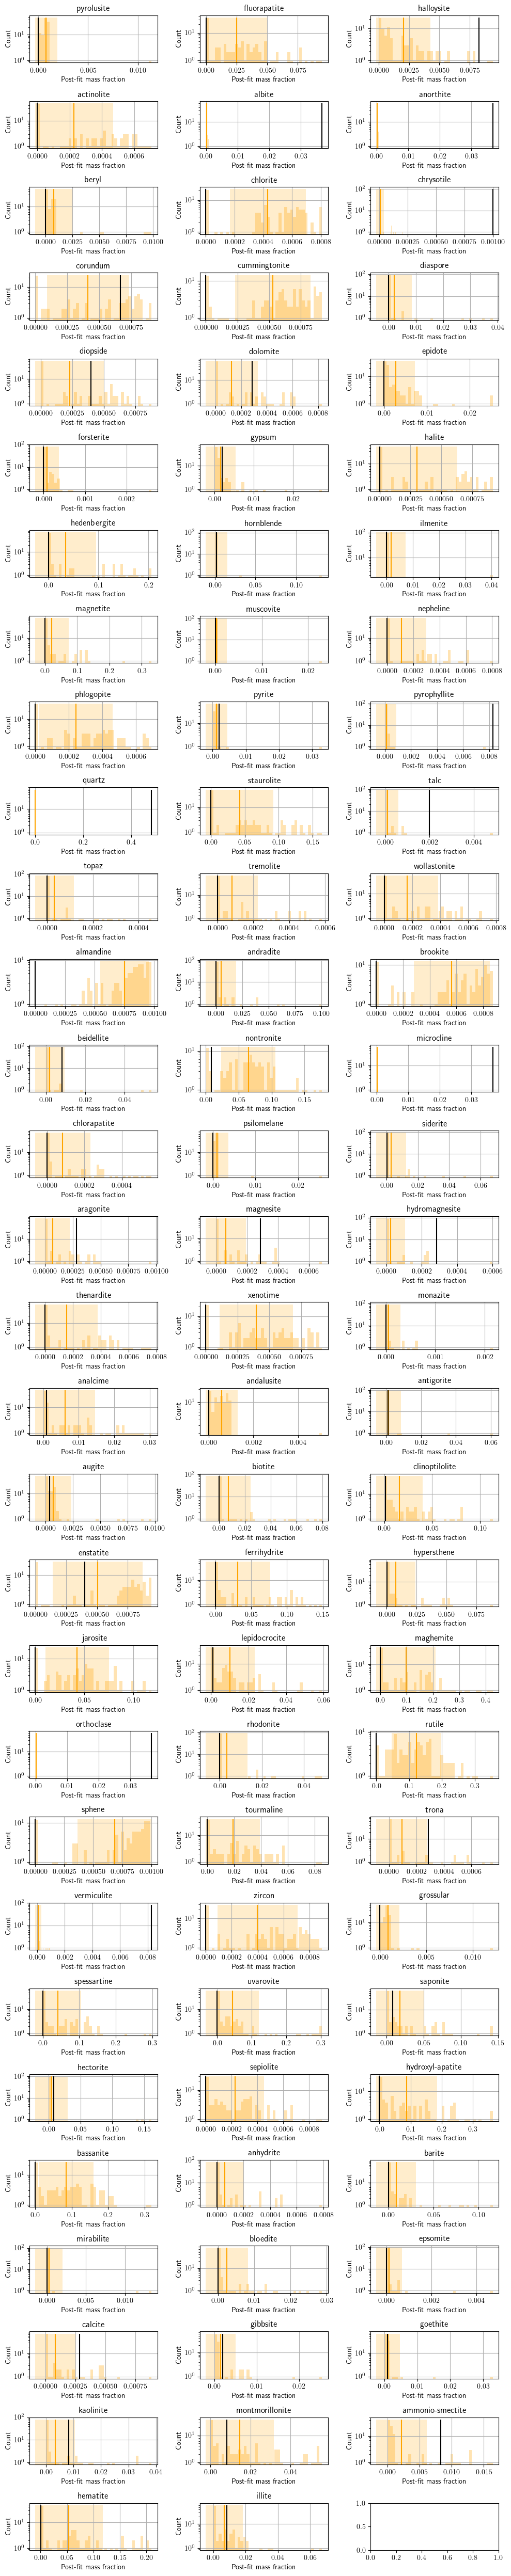

In [94]:
f, axarr = plt.subplots(int(np.ceil(KEndmembers/3.)),3,figsize=(10,50))

curr_row = 0
index = 0

for iEndmember in tqdm(range(model.ms.detach().numpy().shape[1])):

    col = index % 3
    
    tcorrms = np.array(model.ms.tolist())
    tcorrms = (tcorrms > 0.0).astype('float32') * tcorrms
    tcorrms = (tcorrms.T / (np.sum(tcorrms,axis=1)) * (1-msoc)).T 
    
    # plot endmember distribution histogram
    th = axarr[curr_row,col].hist(tcorrms[:,iEndmember],bins=40,color='orange',alpha=0.3)
    
    # add mean and standard deviation bar overlay
    avg = np.mean(tcorrms[:,iEndmember])
    sd = np.sqrt(np.var(tcorrms[:,iEndmember]))
    axarr[curr_row,col].add_patch(Rectangle((avg-sd,0),sd*2,np.max(th[0])*1.05,facecolor="orange",alpha=0.2));
    axarr[curr_row,col].vlines(avg, ymin=0,ymax=np.max(th[0])*1.05,color='orange')
    
    # style
    axarr[curr_row,col].set_title(endMemList[iEndmember])
    axarr[curr_row,col].set_xlabel("Post-fit mass fraction")
    axarr[curr_row,col].set_ylabel("Count")
    axarr[curr_row,col].grid()
    axarr[curr_row,col].set_yscale('log')
    
    if endMemList[iEndmember] in seedMsDict :
        axarr[curr_row,col].vlines(seedMsDict[endMemList[iEndmember]],ymin=0,ymax=np.max(th[0]*1.05),color="black")

    # we have finished the current row, so increment row counter
    if col == 2 :
        curr_row += 1
    index +=1
    
    
f.tight_layout()
plt.show()

In [44]:
import pickle

with open('step2_systematics_N100_Np999_E1p5k_init.pkl', 'wb') as file:
        pickle.dump((model,F,seedFsoc,trueFsoc,seedMs,dataIndices,msoc,rhorads,seedSOCrr,trueSOCrr), file)

In [6]:
import pickle

with open('step2_systematics_N100_Np999_E1p5k_init.pkl', 'rb') as file:
        (model,F,seedFsoc,trueFsoc,seedMs,dataIndices,msoc,rhorads,seedSOCrr,trueSOCrr) = pickle.load(file)

## Serialize analysis

In [46]:
offset = 0

for i in range(100) :
    
    # generate msoc
    dataIndices = np.random.choice(NData,NPoints,replace=False)
    msoc = sample_soc[dataIndices]/100.0
    
    # generate new seed Fsoc
    tempFsoc = np.sum(dataI.T * sample_soc,axis=1)/np.sum(sample_soc)
    seedFsoc = tempFsoc - 0.125*gaus(1.0,0.5)*np.sum(fakeTrough((np.zeros([1,MSpectra])+XF).T,np.array(organicTroughs),3000*gaus(1.0,0.25,len(organicTroughs))).T,axis=0)

    # generate new seedMs
    seedMs = genSeedMs()
    
    # generate new seedSOCrr
    seedSOCrr = (np.mean(rhorads)*gaus(1.0,0.2))
    
    # convert to torch
    tF       = torch.tensor(F[:-1,:].tolist())
    tFsoc    = torch.tensor(seedFsoc.tolist())
    tseedMs  = torch.tensor(seedMs[:,:-1].tolist())
    tmsoc    = torch.tensor(msoc.tolist())
    trhorads = torch.tensor(rhorads.tolist())
    trrsoc   = torch.tensor(seedSOCrr)
    
    # empirical data: (SOC values, reflectances, and max normalized reflectance)
    ys = (tmsoc,torch.tensor(dataI[dataIndices].tolist()),torch.tensor([]))
    
    # run model fit
    model = LinearMixingModel(tF,tFsoc,tseedMs,trhorads,trrsoc)
    optimizer = optim.Adam(model.parameters(), lr = 0.0001, betas=(0.85,0.99))

    print("\t - Training model",i)
    for epoch in range(1) :
        loss = model(ys)
        e = torch.mean(loss)
        e.backward()
        optimizer.step()
        optimizer.zero_grad()

    print("Epoch ",epoch,": ", loss.detach().item())

    with open('step2_systematics_N100_Np999_E1p5k_%i.pkl'%(i+offset), 'wb') as file:
        pickle.dump((model,F,seedFsoc,trueFsoc,seedMs,dataIndices,msoc,rhorads,seedSOCrr,trueSOCrr), file)
        

	 - Training model 0
Epoch  0 :  42592.01171875
	 - Training model 1
Epoch  0 :  43644.734375
	 - Training model 2
Epoch  0 :  45195.79296875
	 - Training model 3
Epoch  0 :  44516.02734375
	 - Training model 4
Epoch  0 :  43332.8046875
	 - Training model 5
Epoch  0 :  42539.0546875
	 - Training model 6
Epoch  0 :  41791.9453125
	 - Training model 7
Epoch  0 :  39030.078125
	 - Training model 8
Epoch  0 :  43832.765625
	 - Training model 9
Epoch  0 :  41644.16015625
	 - Training model 10
Epoch  0 :  45789.3671875
	 - Training model 11
Epoch  0 :  43860.3203125
	 - Training model 12
Epoch  0 :  42388.57421875
	 - Training model 13
Epoch  0 :  46004.12890625
	 - Training model 14
Epoch  0 :  40004.5390625
	 - Training model 15
Epoch  0 :  44643.3515625
	 - Training model 16
Epoch  0 :  41607.046875
	 - Training model 17
Epoch  0 :  43379.34375
	 - Training model 18
Epoch  0 :  42995.0234375
	 - Training model 19
Epoch  0 :  43127.984375
	 - Training model 20
Epoch  0 :  42062.734375
	 - 

In [55]:
import pickle

rrs=[]
socspecs = np.zeros([MSpectra,101])
ms = np.zeros([NPoints,KEndmembers-1,101])

offset=0

with open('step2_systematics_N100_Np999_E1p5k_init.pkl', 'rb') as file:
        (model,F,seedFsoc,trueFsoc,seedMs,dataIndices,msoc,rhorads,seedSOCrr,trueSOCrr) = pickle.load(file)
        rrs += [model.rrsoc.detach().item()]
        socspecs[:,0] = np.array(model.fsoc.tolist())
        
        tcorrms = np.array(model.ms.tolist())
        tcorrms = (tcorrms > 0.0).astype('float32') * tcorrms
        tcorrms = (tcorrms.T / (np.sum(tcorrms,axis=1)) * (1 - msoc)).T 
        
        ms[:,:,0] = tcorrms
        
        print(model.rrsoc.detach().item())

for i in range(100) :
    
    with open('step2_systematics_N100_Np999_E1p5k_%i.pkl'%(i+offset), 'rb') as file:
        (model,F,seedFsoc,trueFsoc,seedMs,dataIndices,msoc,rhorads,seedSOCrr,trueSOCrr) = pickle.load(file)

        rrs += [model.rrsoc.detach().item()]
        
        socspecs[:,i+1] = np.array(model.fsoc.tolist())
        
        tcorrms = np.array(model.ms.tolist())
        tcorrms = (tcorrms > 0.0).astype('float32') * tcorrms
        tcorrms = (tcorrms.T / (np.sum(tcorrms,axis=1)) * (1-msoc)).T 
        
        ms[:,:,i+1] = tcorrms
    

2.4045392158564525


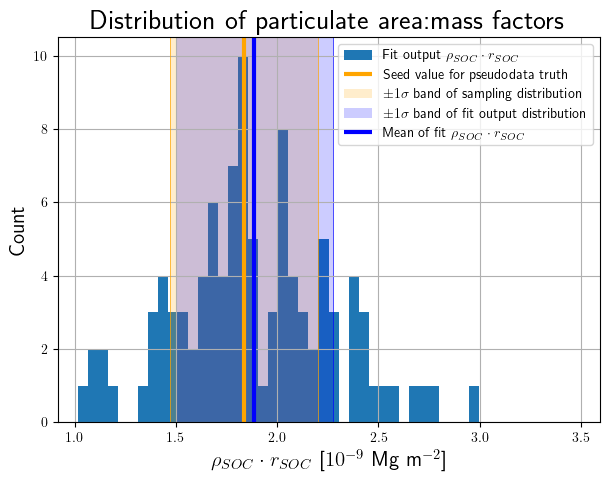

In [51]:
fig, ax = plt.subplots(1,1,figsize=(7,5))

th = plt.hist(np.array(rrs),bins=40,zorder=0,label=r'Fit output $\rho_{SOC} \cdot r_{SOC}$')
#plt.vlines(rrs[0],ymin=0,ymax=30,color='orange')
plt.xlim([np.min(th[1])*0.9,np.max(th[1])*1.2])
plt.ylim([0,np.max(th[0])*1.05])
plt.grid()

plt.xlabel(r'$\rho_{SOC} \cdot r_{SOC}$ [$10^{-9}$ Mg m$^{-2}$]',fontsize=15)
plt.ylabel(r'Count',fontsize=15)
plt.title(r'Distribution of particulate area:mass factors',fontsize=20)

plt.vlines(trueSOCrr,ymin=0,ymax=np.max(th[0])*1.05,color='orange',label=r'Seed value for pseudodata truth',lw=3);
ax.add_patch(Rectangle((trueSOCrr*0.8,0),trueSOCrr*0.4,np.max(th[0])*1.05,facecolor="orange",alpha=0.2,label=r'$\pm1\sigma$ band of sampling distribution'));


# Empirical average and variance are computed
avg = np.mean(np.array(rrs))
sd = np.sqrt(np.var(np.array(rrs)))
ax.add_patch(Rectangle((avg-sd,0),sd*2,np.max(th[0])*1.05,facecolor="blue",alpha=0.2,label=r'$\pm1\sigma$ band of fit output distribution'));
plt.vlines(avg,ymin=0,ymax=np.max(th[0])*1.05,color='blue',label=r'Mean of fit $\rho_{SOC}\cdot r_{SOC}$',lw=3);
ax.vlines(trueSOCrr*0.8,ymin=0,ymax=np.max(th[0])*1.05,color='orange',lw=0.5);
ax.vlines(trueSOCrr*1.2,ymin=0,ymax=np.max(th[0])*1.05,color='orange',lw=0.5);
ax.vlines(avg-sd,ymin=0,ymax=np.max(th[0])*1.05,color='blue',lw=0.5,zorder=1);
ax.vlines(avg+sd,ymin=0,ymax=np.max(th[0])*1.05,color='blue',lw=0.5,zorder=1);

plt.legend(loc='best')

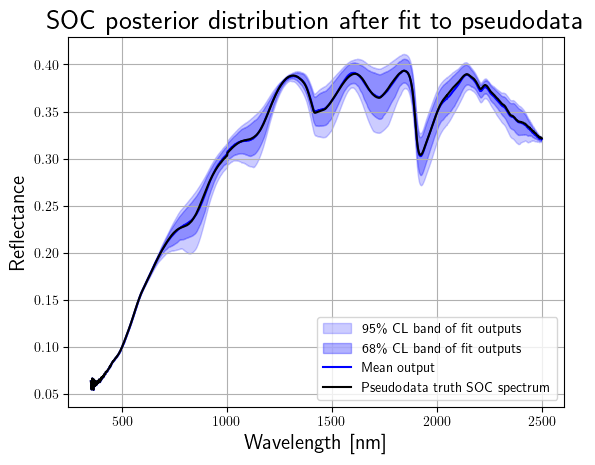

In [52]:
#plt.fill_between(XF,np.quantile(socspecs,0.99,axis=1),np.quantile(socspecs,0.01,axis=1),color='blue',alpha=0.1,label=r'99\% CL band')
plt.fill_between(XF,np.quantile(socspecs,0.95,axis=1),np.quantile(socspecs,0.05,axis=1),color='blue',alpha=0.2,label=r'95\% CL band of fit outputs')
plt.fill_between(XF,np.quantile(socspecs,0.84,axis=1),np.quantile(socspecs,0.16,axis=1),color='blue',alpha=0.3,label=r'68\% CL band of fit outputs')

#plt.plot(XF,np.mean(socspecs,axis=1), color='orange',lw=0.5, label=r'Mean of fit outputs');

plt.plot(XF,np.mean(socspecs,axis=1), color='blue', label=r'Mean output');
plt.plot(XF,seedFsoc, color='black', label=r'Pseudodata truth SOC spectrum');

plt.xlabel(r'Wavelength [nm]',fontsize=15)
plt.ylabel(r'Reflectance',fontsize=15)
plt.title(r'SOC posterior distribution after fit to pseudodata',fontsize=20)

plt.grid()
plt.legend();

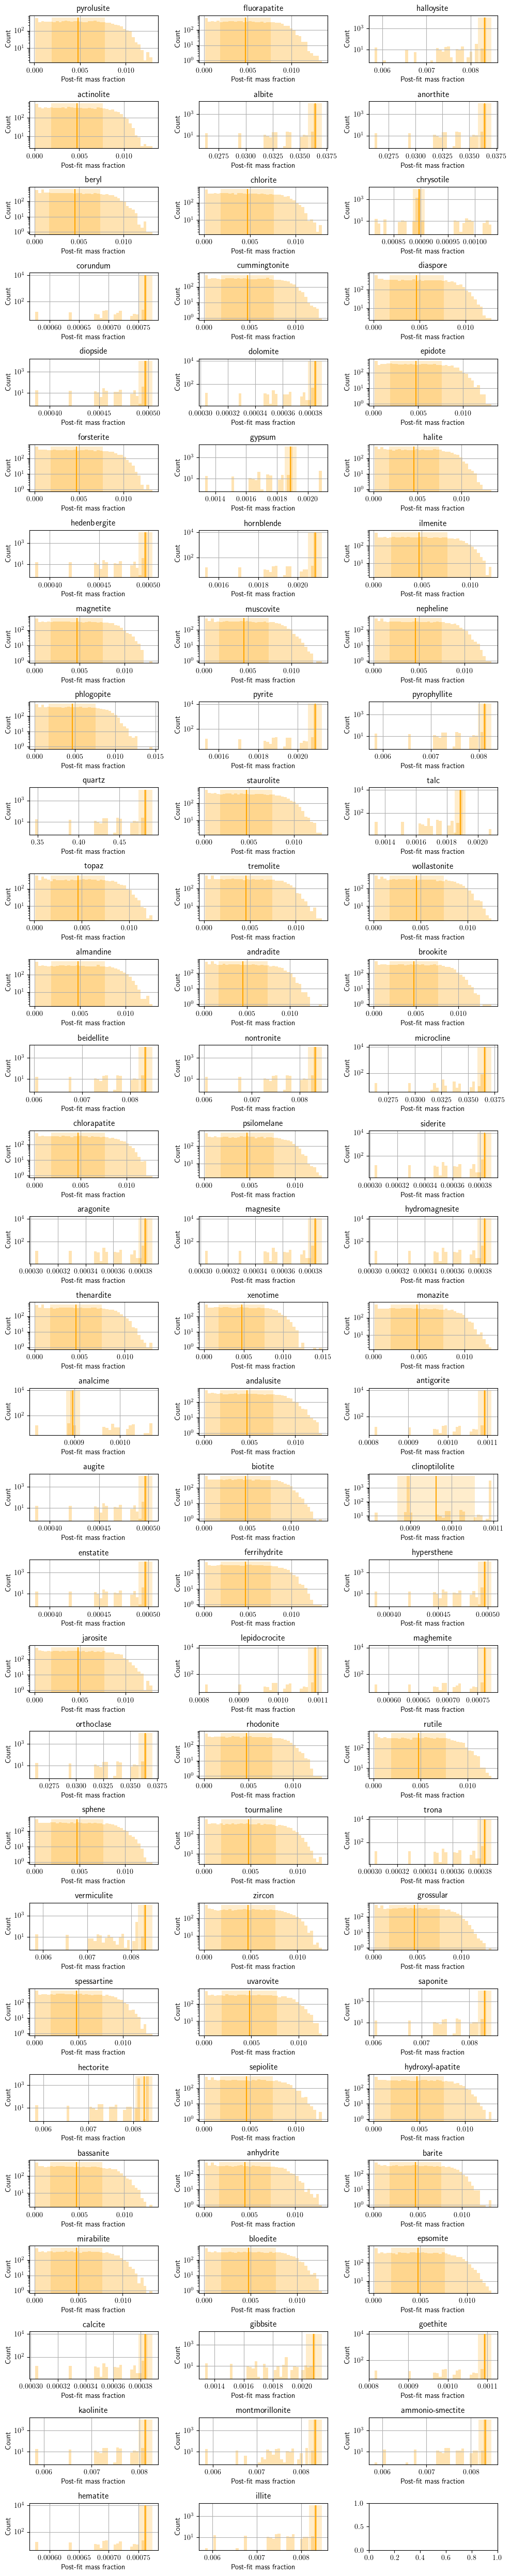

In [59]:
f, axarr = plt.subplots(int(np.ceil(KEndmembers/3.)),3,figsize=(10,50))

curr_row = 0
index = 0

for iEndmember in range(ms.shape[1]):

    col = index % 3
    # plot endmember distribution histogram
    th = axarr[curr_row,col].hist(ms[:,iEndmember,:].flatten(),bins=40,color='orange',alpha=0.3)
    
    # add mean and standard deviation bar overlay
    avg = np.mean(ms[:,iEndmember,:].flatten())
    sd = np.sqrt(np.var(ms[:,iEndmember,:].flatten()))
    axarr[curr_row,col].add_patch(Rectangle((avg-sd,0),sd*2,np.max(th[0])*1.05,facecolor="orange",alpha=0.2));
    axarr[curr_row,col].vlines(avg, ymin=0,ymax=np.max(th[0])*1.05,color='orange')
    
    # style
    axarr[curr_row,col].set_title(endMemList[iEndmember])
    axarr[curr_row,col].set_xlabel("Post-fit mass fraction")
    axarr[curr_row,col].set_ylabel("Count")
    axarr[curr_row,col].grid()
    axarr[curr_row,col].set_yscale('log')

    # we have finished the current row, so increment row counter
    if col == 2 :
        curr_row += 1
    index +=1
    
    
f.tight_layout()
plt.show()